## Analysis of traffic accidents in Leipzig

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import plugins
import networkx as nx
import osmnx as ox

C:\Users\Yannik.SCHREINER\AppData\Local\Temp\ipykernel_17200\511033183.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_trafacc.index = pd.to_datetime(df_trafacc.index.str.replace(r'(\d)\.Qu\. (\d+)', r'\2-Q\1', regex=True))


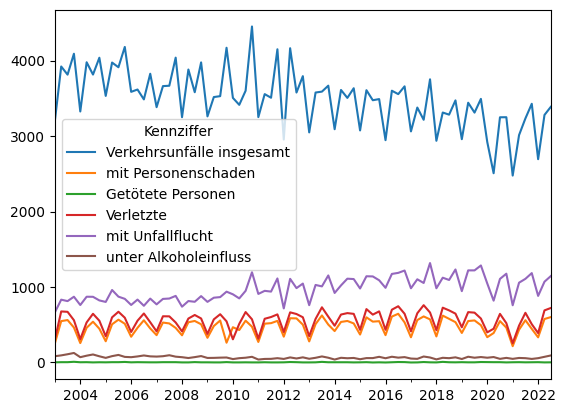

In [2]:
# traffic accidents from opendata portal
df_trafacc = pd.read_csv("https://statistik.leipzig.de/opendata/api/"
                         "values?kategorie_nr=10&rubrik_nr=3&periode=q&format=csv").transpose()
df_trafacc.columns = df_trafacc.iloc[0]
df_trafacc = df_trafacc[2:]
# convert index to datetime
df_trafacc.index = pd.to_datetime(df_trafacc.index.str.replace(r'(\d)\.Qu\. (\d+)', r'\2-Q\1', regex=True))
df_trafacc.plot()
plt.show()

### Playing around with osmnx package (openstreetmap x networkx)

#### Create interactive map for tram network in Leipzig

In [3]:
# custom filter for tram
cf = '["railway"~"tram"]'
# download the tram network for Leipzig by using custom filter
G = ox.graph_from_place("Leipzig, Deutschland", custom_filter=cf)
# plot the tram network with folium
m1 = ox.plot_graph_folium(G, popup_attribute="name", weight=2, color="#8b0000")
# save as html file then display map as an iframe
filepath = "tram.html"
m1.save(filepath)

#### Create interactive map with route from one node to destination node

In [4]:
# download the street network for Leipzig
G = ox.graph_from_place("Leipzig, Deutschland", network_type="bike")
# use networkx to calculate the shortest path between two nodes
origin_node = list(G.nodes())[0]
destination_node = list(G.nodes())[-1]
route = nx.shortest_path(G, origin_node, destination_node)
# plot the route with folium
# like above, you can pass keyword args along to folium PolyLine to style the lines
m2 = ox.plot_route_folium(G, route, weight=10)
# save as html file then display map as an iframe
filepath = "route.html"
m2.save(filepath)

### Create interactive map with opendata accident data

In [5]:
# https://unfallatlas.statistikportal.de/, but they somehow get similar edge size which is better for comparison
# all accidents
df_all_acc = pd.read_csv("https://opendata.leipzig.de/dataset/479aea7a-fd31-433b-a714-221625376120/resource/"
                          "2e8950bf-af9e-4a6e-bc56-f4886635999e/download/unfallatlasleipzig20162020.csv")

# create date column (weekdays not working properly)
df_all_acc["date"] = pd.to_datetime(df_all_acc['UJAHR'].astype(str) + "-" +
                                     df_all_acc['UMONAT'].astype(str).str.zfill(2) + "-" +
                                     (df_all_acc['UWOCHENTAG']-1).astype(str),
                                     format="%Y-%m-%w")

# coordinates of Leipzig
lat = 51.3406321
lng = 12.3747329

# load street network of Leipzig, change dist to get more nodes/edges (e.g. to 7000)
# change network_type to other options like bike and filter df_all_acc only for bike accidents?
G = ox.graph_from_point((lat, lng), dist=5000, network_type='drive')

# find the nearest edge for each accident location and create a new column 'edge'
df_all_acc['edge'] = ox.nearest_edges(G, df_all_acc['XGCSWGS84'], df_all_acc['YGCSWGS84'], return_dist=False)
# Create a new dataframe that counts the number of accidents for each edge
accidents_per_edge = df_all_acc.groupby('edge').size().reset_index(name='accident_count')

# Create a new graph that only includes the edges where accidents happened
edges_with_accidents = accidents_per_edge['edge'].values.tolist()
G = G.edge_subgraph(edges_with_accidents)

# Normalize the accident counts by the length of each edge
for u, v, k, data in G.edges(keys=True, data=True):
    length = data['length']
    edge_id = data['osmid']
    if (u, v, k) in accidents_per_edge['edge'].values.tolist():
        accidents = accidents_per_edge.loc[accidents_per_edge['edge'] == (u, v, k), 'accident_count'].iloc[0]
        # "accident density"
        density = accidents / length
        G.edges[u, v, k]['density'] = density
        G.edges[u, v, k]['accident_count'] = accidents
    else:
        G.edges[u, v, k]['density'] = 0
        G.edges[u, v, k]['accident_count'] = 0

# Create a color map with a legend
color_map = folium.Map(
    location=[lat, lng],
    zoom_start=13,
    control_scale=True,
    tiles='cartodbpositron')

color_scale = folium.LinearColormap(
    colors=['green', 'yellow', 'red'],
    vmin=0,
    vmax=0.1,
    caption='Density of accidents')

legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 150px; height: 150px; 
                border:2px solid grey; z-index:9999; font-size:14px;
                background-color: white;
                ">
        <p style="margin: 10px;"><strong>Accident Density</strong></p>
        <p style="margin: 10px;"><span style="background:green;">&nbsp;&nbsp;</span> Low</p>
        <p style="margin: 10px;"><span style="background:yellow;">&nbsp;&nbsp;</span> Medium</p>
        <p style="margin: 10px;"><span style="background:red;">&nbsp;&nbsp;</span> High</p>
    </div>
'''

color_map.get_root().html.add_child(folium.Element(legend_html))
color_scale.add_to(color_map)

# Plot the street network with the edges colored according to their density of accidents
def get_edge_color(feature):
    edge = (feature['properties']['u'], feature['properties']['v'], feature['properties']['key'])
    density = G.edges[edge]['density']
    return color_scale(density)

# create geojson object from multiGraph which can be plotted on folium map
# for looking at multiGraph object, ox.graph_to_gdfs is the way to go (pandas GeoDataFrame)
edge_geojson = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True).reset_index().to_json()
folium.GeoJson(
    edge_geojson,
    name='Leipzig',
    style_function=lambda feature: {
        'color': get_edge_color(feature),
        'weight': 3
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name', 'accident_count', 'length'],
        aliases=['Street Name', 'Accident Count', 'Length (m)'],
        labels=True,
        sticky=True,
        localize=True  # Format numbers with separators
    )
).add_to(color_map)

# playing around with LayerControl from folium package (based on Leaflet.js)
# add checkbox filter for the accident dataframe flags
ist_rad = folium.LayerControl(
    name='IstRad',
    options={1: 'IstRad'},
    position='topright'
).add_to(color_map)

# Save the map
color_map.save("accident_density_map.html")